In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from cmath import inf

import ase
import matplotlib.pyplot as plt
import metatensor
import numpy as np
import scipy
import torch
from ase.units import Hartree
from IPython.utils import io
from metatensor import Labels
from tqdm import tqdm

import mlelec.metrics as mlmetrics
from mlelec.data.dataset import MLDataset, MoleculeDataset, get_dataloader
from mlelec.features.acdc import compute_features_for_target
from mlelec.models.linear import LinearTargetModel
from mlelec.utils.dipole_utils import (
    compute_batch_dipole_moment,
    compute_batch_polarisability,
    compute_dipole_moment,
    compute_eigvals,
    compute_polarisability,
    instantiate_mf,
)
from mlelec.utils.twocenter_utils import (
    _to_matrix,
    _to_uncoupled_basis,
    unfix_orbital_order,
)

Using PyTorch backend.


In [18]:
torch.set_default_dtype(torch.float64)

# ------------------ CHANGE THE PARAMETERS -------------
NUM_FRAMES = 1000
BATCH_SIZE = 100
NUM_EPOCHS = 1000
SHUFFLE_SEED = 1234
TRAIN_FRAC = 0.7
TEST_FRAC = 0.1
VALIDATION_FRAC = 0.2
LR = 0.0001
VAL_INTERVAL = 10
W_EVA: 100000.0
W_DIP: 10000.0
W_POL: 1000.0
DEVICE = "cpu"
ORTHOGONAL = False
FOLDER_NAME = "multitask_learn_non-orthogonal"
NOISE = False
# ---------------------------------------------------------

In [4]:
# Helper function to drop blocks in the train, validation and test subset that have zero samples due to splitting of the dataset

def drop_zero_blocks(train_tensor, val_tensor, test_tensor):
    for i1, b1 in train_tensor.items():
        if b1.values.shape[0] == 0:
            train_tensor = metatensor.drop_blocks(train_tensor,
                                                  Labels(i1.names, i1.values.reshape(1,-1)))

    for i2, b2 in val_tensor.items():
        if b2.values.shape[0] == 0:
            val_tensor = metatensor.drop_blocks(val_tensor,
                                                Labels(i2.names, i2.values.reshape(1,-1)))

    for i3, b3 in test_tensor.items():
        if b3.values.shape[0] == 0:
            test_tensor = metatensor.drop_blocks(test_tensor,
                                                 Labels(i3.names, i3.values.reshape(1,-1)))

    return train_tensor, val_tensor, test_tensor

def loss_fn_combined(
    ml_data,
    pred_focks,
    mfs,
    indices,
    frames,
    eigval,
    polar,
    dipole,
    var_polar,
    var_dipole,
    var_eigval,
    weight_eigval = 1.0,
    weight_polar = 1.0,
    weight_dipole = 1.0):
    
    pred_dipole, pred_polar, pred_eigval = compute_batch_polarisability(ml_data, pred_focks, indices, mfs)

    loss_polar = loss_fn(frames, pred_polar, polar)/var_polar
    loss_dipole = loss_fn(frames, pred_dipole, dipole)/var_dipole
    loss_eigval = loss_fn(frames, pred_eigval, eigval)/var_eigval
    
    # weighted sum of the various loss contributions
    return (
        weight_eigval * loss_eigval
        + weight_dipole * loss_dipole
        + weight_polar * loss_polar,
        loss_eigval,
        loss_dipole,
        loss_polar
    )

In [5]:
molecule_data = MoleculeDataset(
    mol_name="qm7",
    use_precomputed=True,
    path="examples/data/qm7",
    aux_path="examples/data/qm7/sto-3g",
    frame_slice=slice(0, NUM_FRAMES),
    device=DEVICE,
    aux=["overlap", "orbitals"],
    lb_aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment", "polarisability"],
    lb_target=["fock", "dipole_moment", "polarisability"],
)

Loading structures
examples/data/qm7/sto-3g/fock.hickle
examples/data/qm7/sto-3g/dipole_moment.hickle
examples/data/qm7/sto-3g/polarisability.hickle
examples/data/qm7/def2-tzvp/fock.hickle
examples/data/qm7/def2-tzvp/dipole_moment.hickle
examples/data/qm7/def2-tzvp/polarisability.hickle


In [6]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=DEVICE,
    model_strategy="coupled",
    shuffle=True,
    shuffle_seed=SHUFFLE_SEED,
    orthogonal=ORTHOGONAL,  # set this to false if you want to train in the non-orthogonal basis
)

ml_data._split_indices(train_frac=TRAIN_FRAC, val_frac=VALIDATION_FRAC, test_frac=TEST_FRAC)

In [7]:
hypers = {
            "cutoff": 3.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 4.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = DEVICE, hypers = hypers, hypers_pair = hypers_pair))

train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="blocks", batch_size=BATCH_SIZE)

ml_data.target_train, ml_data.target_val, ml_data.target_test = drop_zero_blocks(ml_data.target_train, ml_data.target_val, ml_data.target_test)

ml_data.feat_train, ml_data.feat_val, ml_data.feat_test = drop_zero_blocks(ml_data.feat_train, ml_data.feat_val, ml_data.feat_test)

## Load a fitted Model

In [19]:
model = LinearTargetModel(dataset=ml_data, nlayers=1, nhidden=16, bias=False, device=DEVICE)

In [20]:
model.load_state_dict(torch.load(f'{FOLDER_NAME}/model_output/model_epoch_950.pt'))

<All keys matched successfully>

### Test on QM7

In [21]:
# Training on large basis targets

ref_polar_lb = molecule_data.lb_target["polarisability"]
ref_dip_lb = molecule_data.lb_target["dipole_moment"]
ref_eva_lb = []
for i in range(len(molecule_data.lb_target["fock"])):
    f = molecule_data.lb_target["fock"][i]
    s = molecule_data.lb_aux_data["overlap"][i]
    eig = scipy.linalg.eigvalsh(f, s)
    ref_eva_lb.append(torch.from_numpy(eig))

ref_polar = molecule_data.target["polarisability"]
ref_dip = molecule_data.target["dipole_moment"]
ref_eva = []
for i in range(len(molecule_data.target["fock"])):
    f = molecule_data.target["fock"][i]
    s = molecule_data.aux_data["overlap"][i]
    eig = scipy.linalg.eigvalsh(f, s)
    ref_eva.append(torch.from_numpy(eig))

var_eigval = torch.cat([ref_eva_lb[i].flatten() for i in range(len(ref_eva_lb))]).var()
var_dipole = torch.cat([ref_dip_lb[i].flatten() for i in range(len(ref_dip_lb))]).var()
var_polar = torch.cat([ref_polar_lb[i].flatten() for i in range(len(ref_polar_lb))]).var()

In [22]:
with io.capture_output() as captured:
    all_mfs, fockvars = instantiate_mf(
        ml_data,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data.structures))),
    )

In [23]:
with io.capture_output() as captured:
    batch_indices = ml_data.train_idx
    train_fock_predictions = model.forward(
        ml_data.feat_train, return_type="tensor", batch_indices=batch_indices
    )
    train_dipole_pred, train_polar_pred, train_eva_pred = compute_batch_polarisability(
        ml_data, train_fock_predictions, batch_indices=batch_indices, mfs=all_mfs, orthogonal=ORTHOGONAL
    )

train_error_pol = mlmetrics.mse_qm7(ml_data.train_frames,
                          train_polar_pred,
                          ref_polar_lb[[i.item() for i in batch_indices]])
train_error_dip = mlmetrics.mse_qm7(ml_data.train_frames,
                          train_dipole_pred,
                          ref_dip_lb[[i.item() for i in batch_indices]])
train_eva_ref = [ref_eva_lb[i][:ml_data.target.tensor[i].shape[0]] for i in batch_indices]
train_error_eva = mlmetrics.mse_qm7(ml_data.train_frames, train_eva_pred, train_eva_ref)

In [24]:
print("Train RMSE on dipole from indirect learning {:.5f} A.U.".format(torch.sqrt(train_error_dip).item()))
print("Train RMSE on polar from indirect learning {:.5f} A.U.".format(torch.sqrt(train_error_pol).item()))
print("Train RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(train_error_eva).item() * Hartree))

Train RMSE on dipole from indirect learning 0.00166 A.U.
Train RMSE on polar from indirect learning 1.02575 A.U.
Train RMSE on MO energies from indirect learning 0.24639 eV.


In [25]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", batch_indices=ml_data.test_idx,
    )
    test_dip_pred, test_polar_pred, test_eva_pred = compute_batch_polarisability(
        ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs, orthogonal=ORTHOGONAL
    )

error_dip = mlmetrics.mse_qm7(ml_data.test_frames,
                              test_dip_pred,
                              ref_dip_lb[[i.item() for i in batch_indices]]
                             )
error_pol = mlmetrics.mse_qm7(ml_data.test_frames, test_polar_pred,
                              ref_polar_lb[[i.item() for i in batch_indices]]
                              )
test_eva_ref = [ref_eva_lb[i][:ml_data.target.tensor[i].shape[0]] for i in batch_indices]
error_eva = mlmetrics.mse_qm7(ml_data.test_frames, test_eva_pred, test_eva_ref)

In [26]:
print("Test RMSE on dipole from indirect learning {:.5f} A.U.".format(torch.sqrt(error_dip).item()))
print("Test RMSE on polar from indirect learning {:.5f} A.U.".format(torch.sqrt(error_pol).item()))
print("Test RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(error_eva).item() * Hartree))

Test RMSE on dipole from indirect learning 0.00859 A.U.
Test RMSE on polar from indirect learning 1.13613 A.U.
Test RMSE on MO energies from indirect learning 0.28321 eV.


In [27]:
error_eva_STO3G = mlmetrics.mse_qm7(ml_data.test_frames,
                                    [ref_eva[i] for i in ml_data.test_idx],
                                    test_eva_ref
                                    )
error_dip_STO3G = mlmetrics.mse_qm7(ml_data.test_frames,
                                    ref_dip[ml_data.test_idx],
                                    ref_dip_lb[ml_data.test_idx]
                                    )
error_polar_STO3G = mlmetrics.mse_qm7(ml_data.test_frames,
                                      ref_polar[ml_data.test_idx],
                                      ref_polar_lb[ml_data.test_idx])

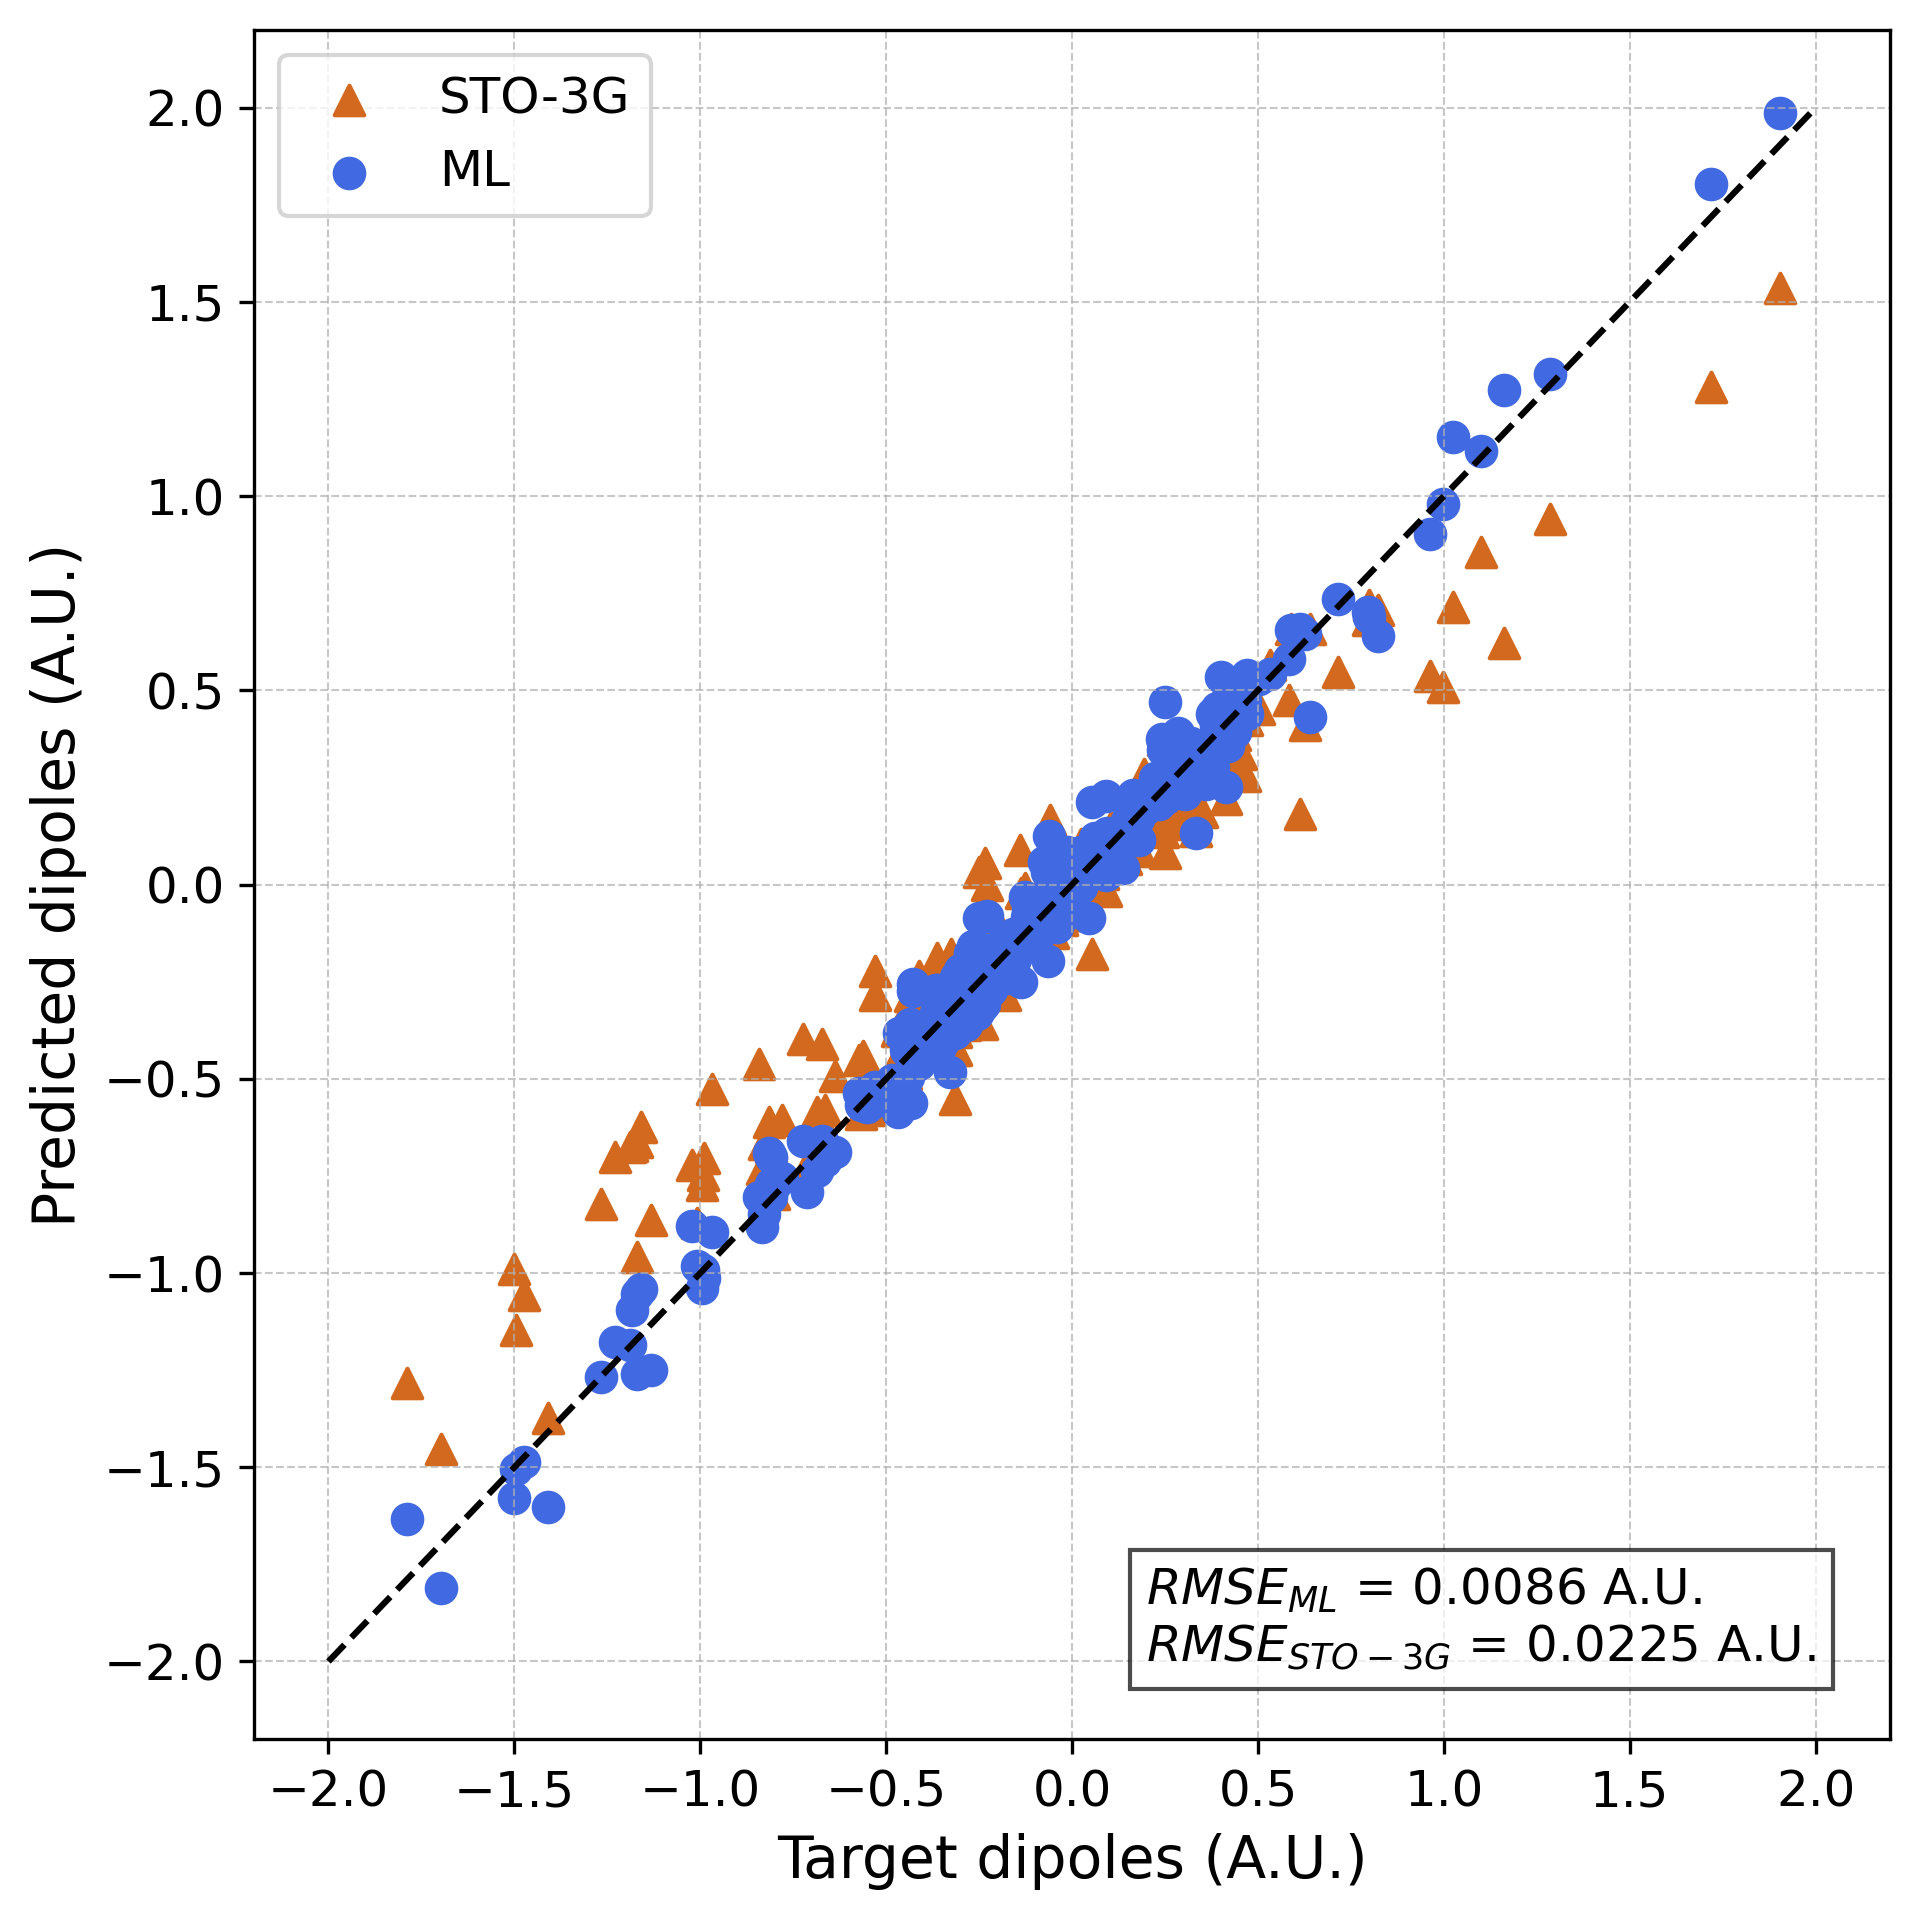

In [28]:
plt.figure(figsize=(6.5,6.5), dpi=300)  # Increase figure size and resolution

# Scatter plots
for predicted, target in zip(ref_dip[ml_data.test_idx], ref_dip_lb[ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='chocolate', marker='^', s=50,  # Increase marker size
                label='STO-3G' if 'STO-3G' not in plt.gca().get_legend_handles_labels()[1] else "")

for predicted, target in zip(test_dip_pred.detach().numpy(), ref_dip_lb[ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='royalblue', s=50,  # Increase marker size
                label='ML' if 'ML' not in plt.gca().get_legend_handles_labels()[1] else "")

# Line plot (diagonal reference line)
plt.plot([-2, 2], [-2, 2], linestyle='--', color='black', linewidth=1.5)  # Thicker line

# Labels
plt.xlabel('Target dipoles (A.U.)', fontsize=14)  # Larger font
plt.ylabel('Predicted dipoles (A.U.)', fontsize=14)

# Grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Text box with RMSE values
rmse_ml = torch.sqrt(error_dip).item()
rmse_sto3g = torch.sqrt(error_dip_STO3G).item()
plt.text(0.2, -2,  # Adjust position of the text box
         f'$RMSE_{{ML}}$ = {rmse_ml:.4f} A.U.\n$RMSE_{{STO-3G}}$ = {rmse_sto3g:.4f} A.U.',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Legend
plt.legend(fontsize=12)

# Ticks
plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure in high resolution (e.g., 300 DPI) and as a vector graphic
plt.savefig(f"{FOLDER_NAME}/mse_dipole_indirect.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"{FOLDER_NAME}/mse_dipole_indirect.svg", bbox_inches="tight")  # For vector format

plt.show()

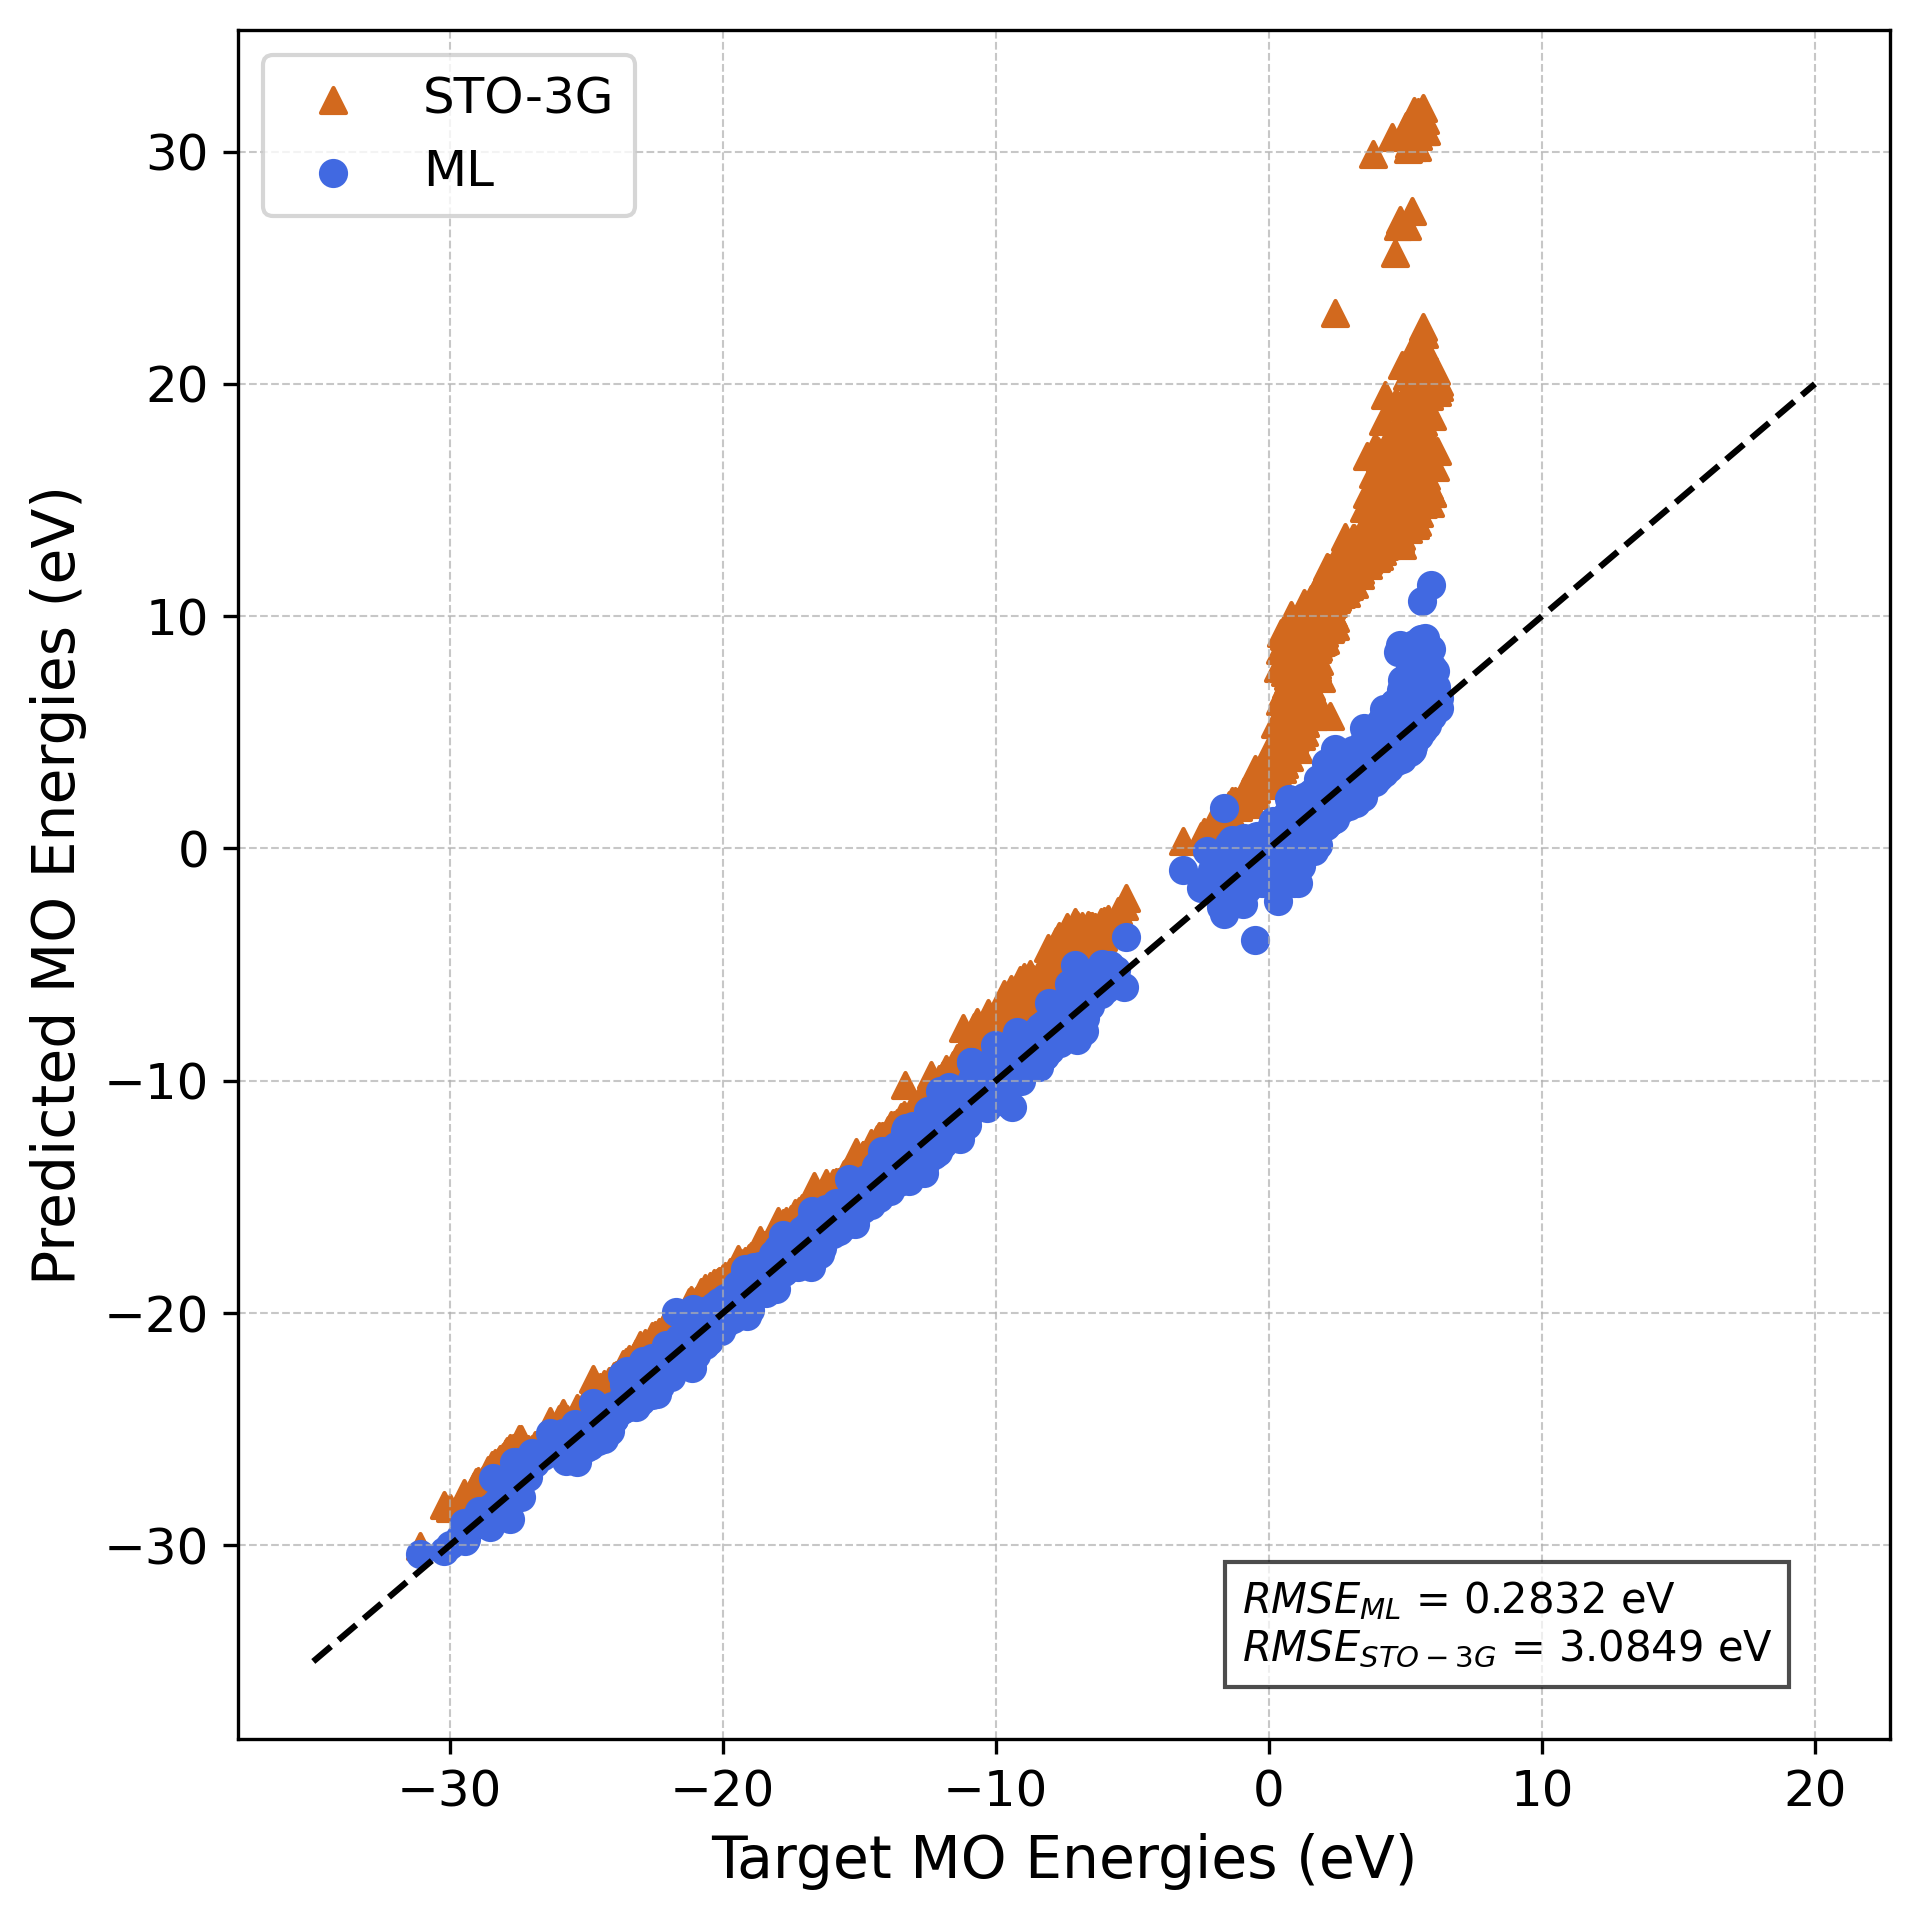

In [29]:
plt.figure(figsize=(6.5,6.5), dpi=300)  # Increase figure size and resolution
for target, predicted in zip(test_eva_ref, [ref_eva[i] for i in ml_data.test_idx]):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree

    x = x[x > -100]
    y = y[y > -100]
    plt.scatter(x, y, color='chocolate', marker='^',
                label='STO-3G' if 'STO-3G' not in plt.gca().get_legend_handles_labels()[1] else "")

for target, predicted in zip(test_eva_ref, test_eva_pred):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree

    x = x[x > -100]
    y = y[y > -100]
    plt.scatter(x, y, color='royalblue',
                label='ML' if 'ML' not in plt.gca().get_legend_handles_labels()[1] else "")

    
plt.plot([-35, 20], [-35, 20], linestyle='--', color='black', linewidth=1.5)
plt.xlabel('Target MO Energies (eV)', fontsize=14)
plt.ylabel('Predicted MO Energies (eV)', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

rmse_ml = torch.sqrt(error_eva).item() * Hartree
rmse_sto3g = torch.sqrt(error_eva_STO3G).item() * Hartree
plt.text(-1, -35,
         f'$RMSE_{{ML}}$ = {rmse_ml:.4f} eV\n$RMSE_{{STO-3G}}$ = {rmse_sto3g:.4f} eV',
         fontsize=10,
         bbox=dict(facecolor='white',  alpha=0.7, edgecolor='black'))
plt.legend(fontsize=12, loc='upper left')

plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"{FOLDER_NAME}/mse_eva_indirect.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"{FOLDER_NAME}/mse_eva_indirect.svg", bbox_inches="tight")  # For vector format

plt.show()

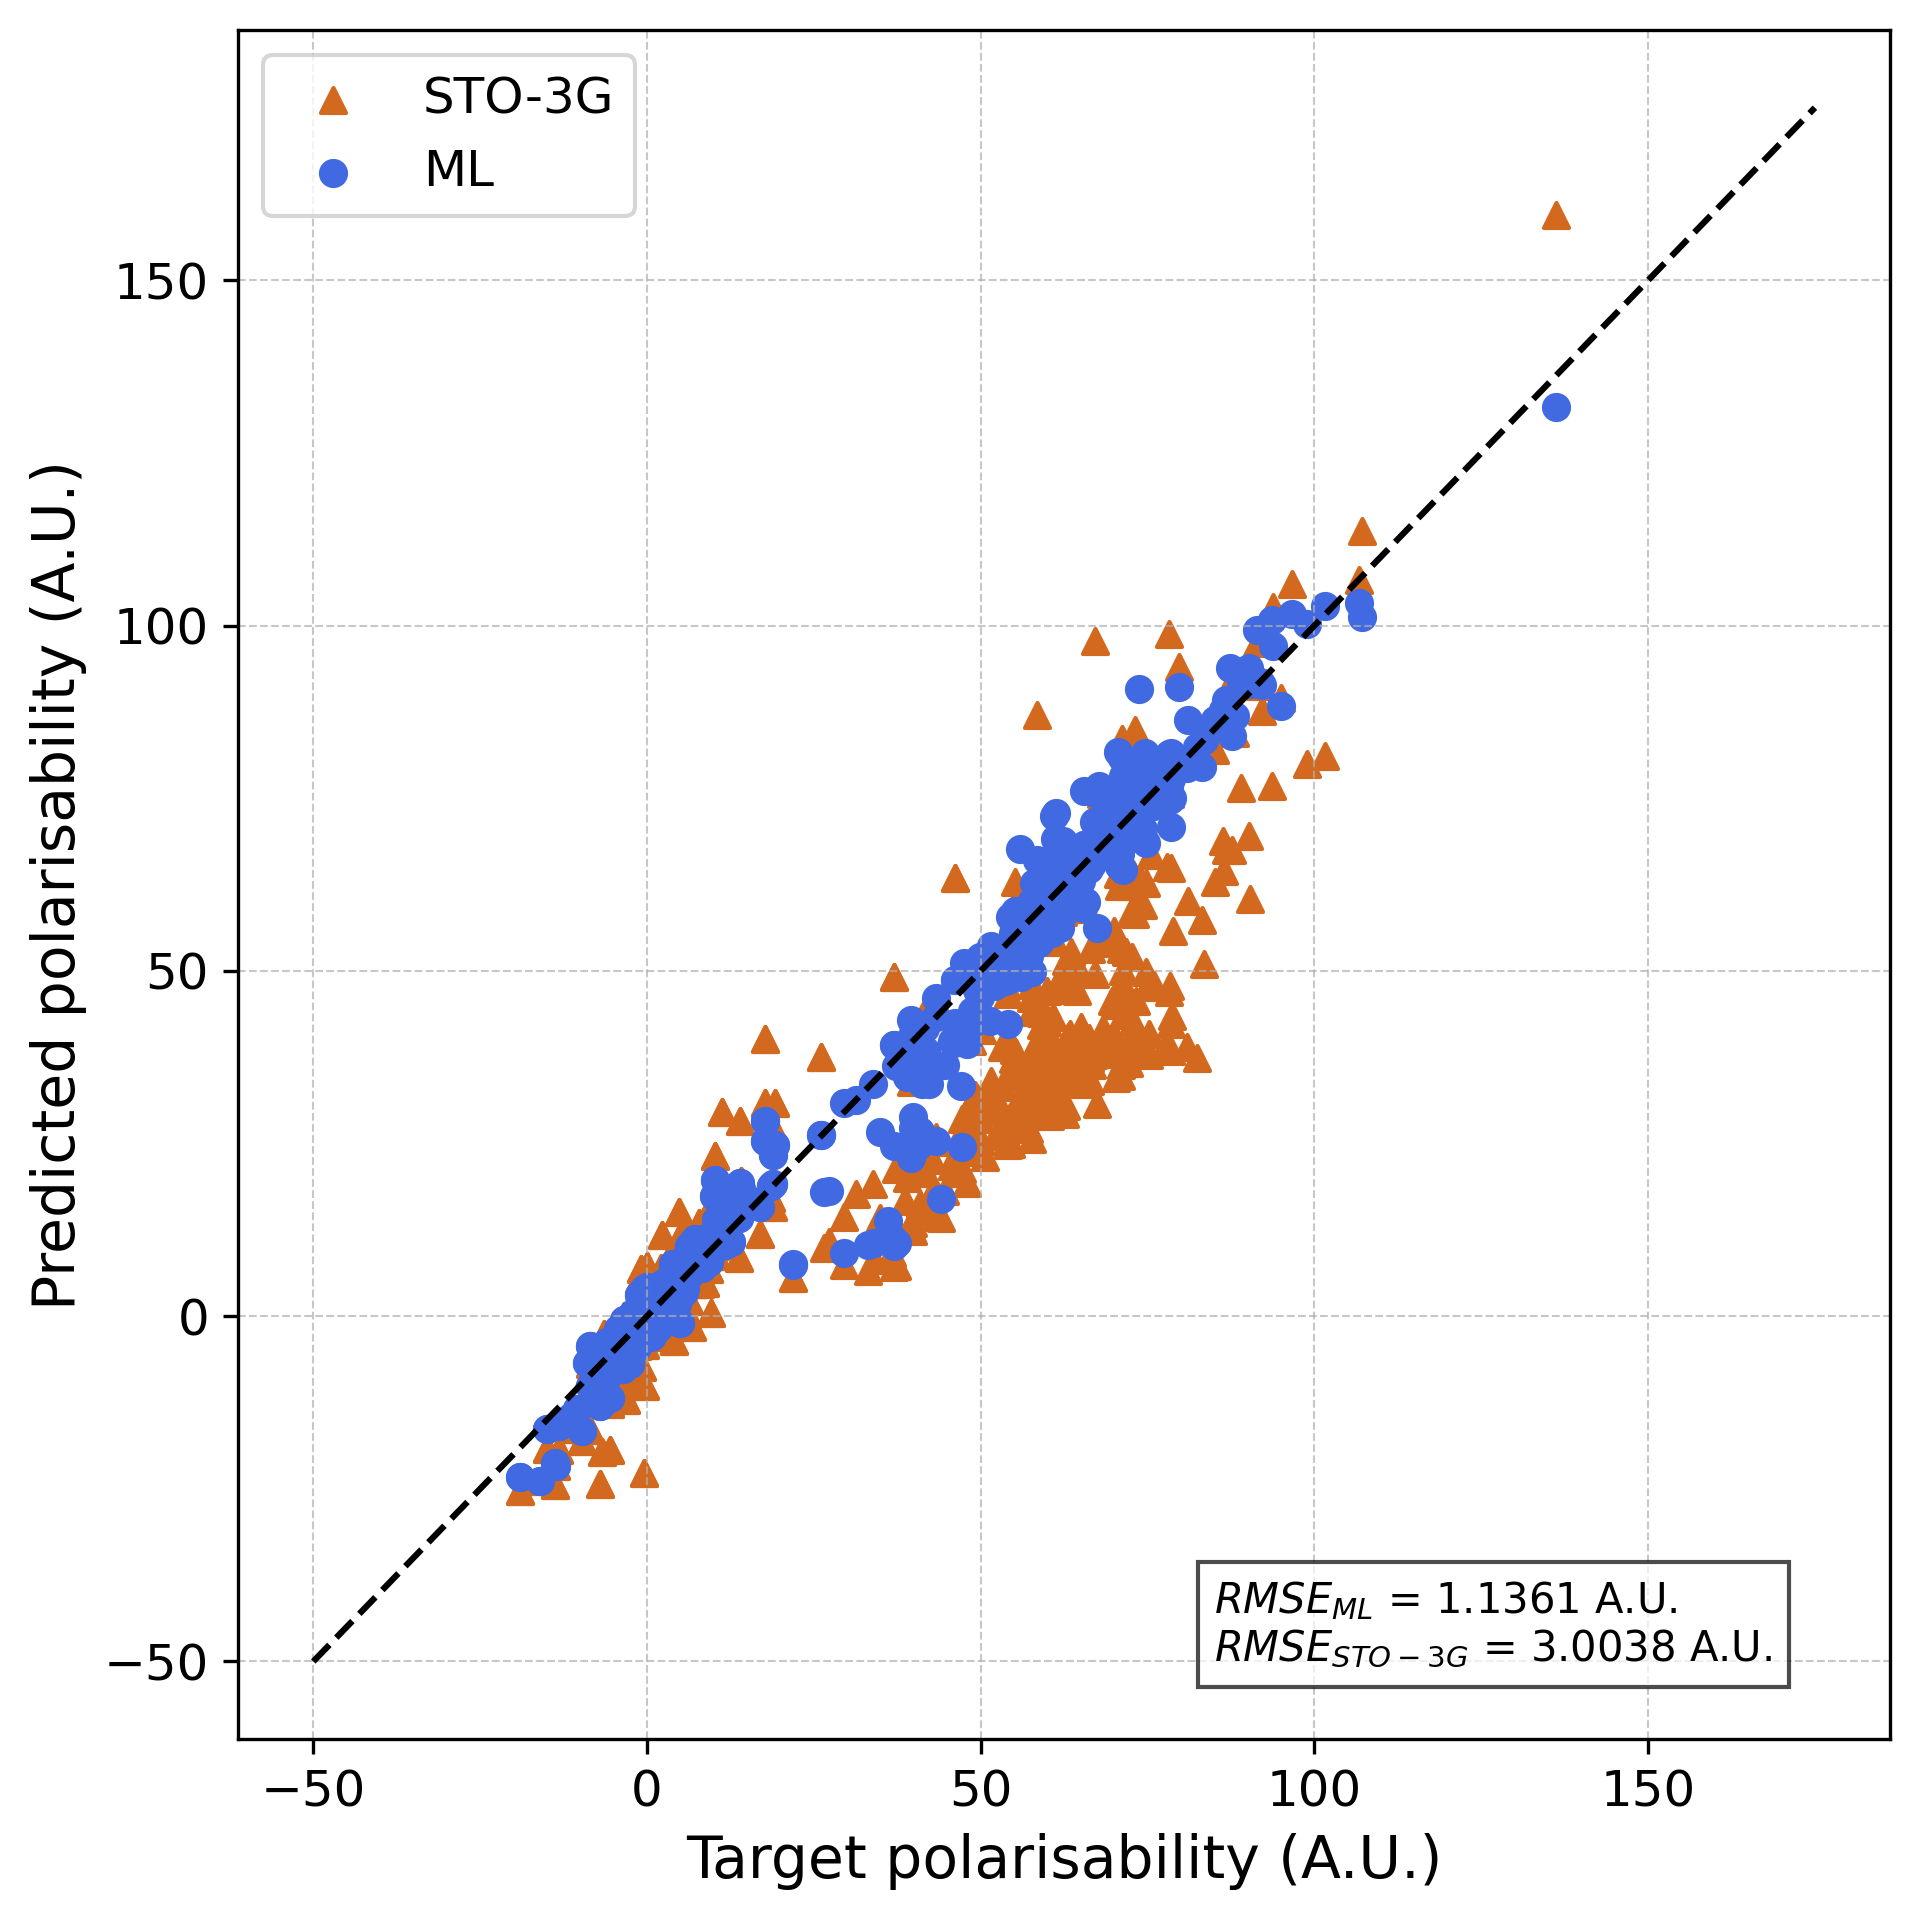

In [30]:
plt.figure(figsize=(6.5,6.5), dpi=300)  # Increase figure size and resolution
for predicted, target in zip(ref_polar[ml_data.test_idx], ref_polar_lb[ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='chocolate', marker='^',
                label='STO-3G' if 'STO-3G' not in plt.gca().get_legend_handles_labels()[1] else "")

for predicted, target in zip(test_polar_pred.detach().numpy(), ref_polar_lb[ml_data.test_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='royalblue', 
                label='ML' if 'ML' not in plt.gca().get_legend_handles_labels()[1] else "")


plt.plot([-50, 175], [-50, 175], linestyle='--', color='black', linewidth=1.5)
plt.xlabel('Target polarisability (A.U.)', fontsize=14)
plt.ylabel('Predicted polarisability (A.U.)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


rmse_ml = torch.sqrt(error_pol).item()
rmse_sto3g = torch.sqrt(error_polar_STO3G).item()
plt.text(85, -50,
         f'$RMSE_{{ML}}$ = {rmse_ml:.4f} A.U.\n$RMSE_{{STO-3G}}$ = {rmse_sto3g:.4f} A.U.',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
plt.legend(fontsize=12, loc='upper left')

plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"{FOLDER_NAME}/mse_polar_indirect.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"{FOLDER_NAME}/mse_polar_indirect.svg", bbox_inches="tight")  # For vector format

plt.show()

## Test on a subset of QM9 

In [31]:
molecule_data_qm9 = MoleculeDataset(
    mol_name = "qm9",
    use_precomputed=True,
    path= "examples/data/qm9",
    aux_path="examples/data/qm9/sto-3g",
    frame_slice=slice(0, 200), # Loads 100 frames 
    device=DEVICE,
    aux=["overlap", "orbitals"],
    lb_aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment", "polarisability"],
    lb_target=["fock", "dipole_moment", "polarisability"],
)

Loading structures
examples/data/qm9/sto-3g/fock.hickle
examples/data/qm9/sto-3g/dipole_moment.hickle
examples/data/qm9/sto-3g/polarisability.hickle
examples/data/qm9/def2-tzvp/fock.hickle
examples/data/qm9/def2-tzvp/dipole_moment.hickle
examples/data/qm9/def2-tzvp/polarisability.hickle


In [32]:
ml_data_qm9 = MLDataset(
    molecule_data=molecule_data_qm9,
    device=DEVICE,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=SHUFFLE_SEED,
    orthogonal=True
) 

In [33]:
ml_data_qm9._split_indices(train_frac=1, val_frac=0, test_frac=0)

In [34]:
ml_data_qm9._set_features(compute_features_for_target(ml_data_qm9, device = DEVICE, hypers = hypers, hypers_pair = hypers_pair))

In [35]:
with io.capture_output() as captured:
    all_mfs_qm9, _ = instantiate_mf(
        ml_data_qm9,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data_qm9.structures))),
    )

In [36]:
qm9_fock_pred_uc = model.forward(
    ml_data_qm9.feat_train, return_type="uncoupled_blocks", batch_indices=ml_data_qm9.train_idx,
)
qm9_fock_predictions = _to_matrix(qm9_fock_pred_uc, ml_data_qm9.train_frames, 
                                   ml_data_qm9.train_idx, ml_data_qm9.molecule_data.aux_data["orbitals"])

In [37]:
qm9_ref_polar_lb = molecule_data_qm9.lb_target["polarisability"]
qm9_ref_dip_lb = molecule_data_qm9.lb_target["dipole_moment"]
qm9_ref_eva_lb = []
for i in range(len(molecule_data_qm9.lb_target["fock"])):
    f = molecule_data_qm9.lb_target["fock"][i]
    s = molecule_data_qm9.lb_aux_data["overlap"][i]
    eig = scipy.linalg.eigvalsh(f, s)
    qm9_ref_eva_lb.append(torch.from_numpy(eig))

qm9_ref_polar = molecule_data_qm9.target["polarisability"]
qm9_ref_dip = molecule_data_qm9.target["dipole_moment"]
qm9_ref_eva = []
for i in range(len(molecule_data_qm9.target["fock"])):
    f = molecule_data_qm9.target["fock"][i]
    s = molecule_data_qm9.aux_data["overlap"][i]
    eig = scipy.linalg.eigvalsh(f, s)
    qm9_ref_eva.append(torch.from_numpy(eig))

In [38]:
with io.capture_output() as captured:
    batch_indices = ml_data_qm9.train_idx
   
    qm9_dipole_pred, qm9_polar_pred, qm9_eva_pred = compute_batch_polarisability(
        ml_data_qm9, qm9_fock_predictions, batch_indices=batch_indices, mfs=all_mfs_qm9, orthogonal=ORTHOGONAL
    )

qm9_error_pol = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
                          qm9_polar_pred,
                          qm9_ref_polar_lb[[i.item() for i in batch_indices]])
qm9_error_dip = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
                          qm9_dipole_pred,
                          qm9_ref_dip_lb[[i.item() for i in batch_indices]])
qm9_eva_ref_lb = [qm9_ref_eva_lb[i][:ml_data_qm9.target.tensor[i].shape[0]] for i in batch_indices]
qm9_error_eva = mlmetrics.mse_qm7(ml_data.train_frames, qm9_eva_pred, qm9_eva_ref_lb)

In [39]:
print("Test RMSE on dipole from indirect learning {:.5f} A.U.".format(torch.sqrt(qm9_error_dip).item()))
print("Test RMSE on polar from indirect learning {:.5f} A.U.".format(torch.sqrt(qm9_error_pol).item()))
print("Test RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(qm9_error_eva).item() * Hartree))

Test RMSE on dipole from indirect learning 0.02610 A.U.
Test RMSE on polar from indirect learning 2.82200 A.U.
Test RMSE on MO energies from indirect learning 0.48822 eV.


In [40]:
qm9_error_eva_STO3G = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
                                    [qm9_ref_eva[i] for i in ml_data_qm9.train_idx],
                                    qm9_eva_ref_lb
                                    )
qm9_error_dip_STO3G = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
                                    qm9_ref_dip[ml_data_qm9.train_idx],
                                    qm9_ref_dip_lb[ml_data_qm9.train_idx]
                                    )
qm9_error_polar_STO3G = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
                                      qm9_ref_polar[ml_data_qm9.train_idx],
                                      qm9_ref_polar_lb[ml_data_qm9.train_idx])

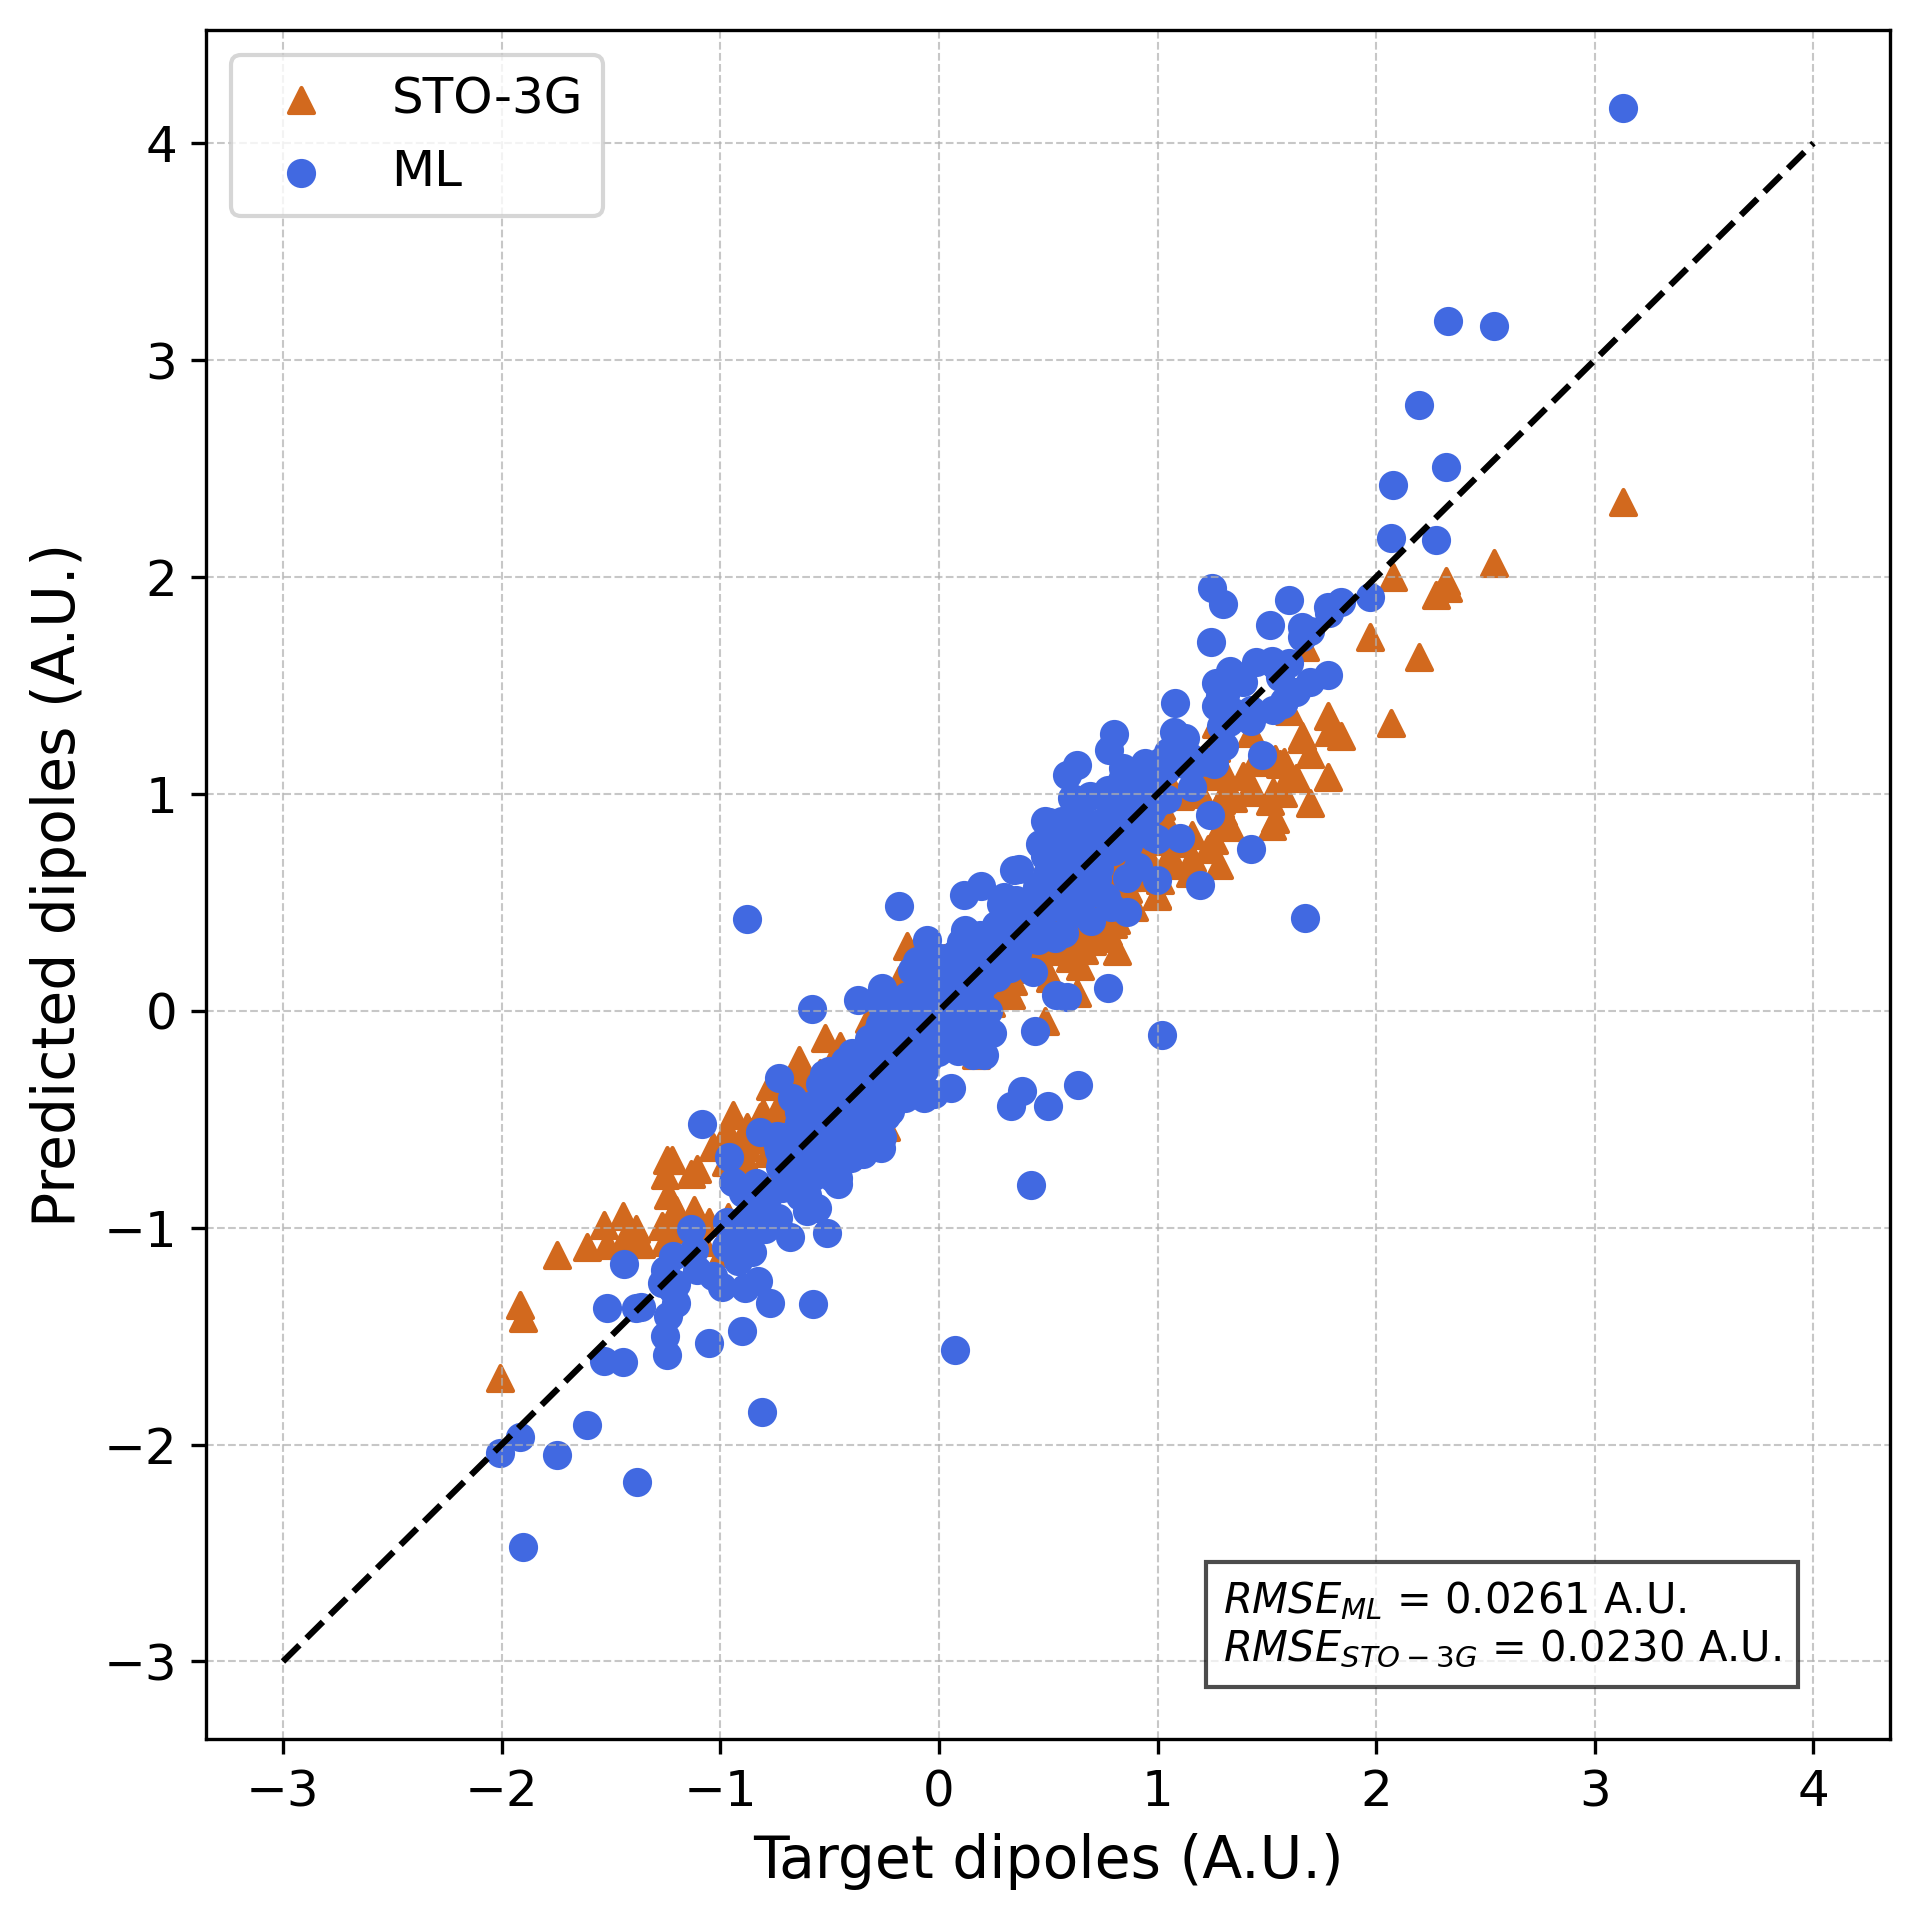

In [41]:
plt.figure(figsize=(6.5,6.5), dpi=300)  # Increase figure size and resolution
for predicted, target in zip(qm9_ref_dip[ml_data_qm9.train_idx], qm9_ref_dip_lb[ml_data_qm9.train_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='chocolate', marker='^',
                label='STO-3G' if 'STO-3G' not in plt.gca().get_legend_handles_labels()[1] else "")
    
for predicted, target in zip(qm9_dipole_pred.detach().numpy(), qm9_ref_dip_lb[ml_data_qm9.train_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='royalblue',
                label='ML' if 'ML' not in plt.gca().get_legend_handles_labels()[1] else "")

# Line plot
plt.plot([-3, 4], [-3, 4], linestyle='--', color='black', linewidth=1.5)

# Labels
plt.xlabel('Target dipoles (A.U.)', fontsize=14)
plt.ylabel('Predicted dipoles (A.U.)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


# Text box
rmse_ml = torch.sqrt(qm9_error_dip).item()
rmse_sto3g = torch.sqrt(qm9_error_dip_STO3G).item()
plt.text(1.3, -3,
         f'$RMSE_{{ML}}$ = {rmse_ml:.4f} A.U.\n$RMSE_{{STO-3G}}$ = {rmse_sto3g:.4f} A.U.',
         fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Legend
plt.legend(fontsize=12, loc='upper left')

plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"{FOLDER_NAME}/qm9_dipole_indirect.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"{FOLDER_NAME}/qm9_dipole_indirect.svg", bbox_inches="tight")  # For vector format

plt.show()
# plt.savefig(f"{FOLDER_NAME}/qm9_dipole_indirect.pdf", bbox_inches="tight")

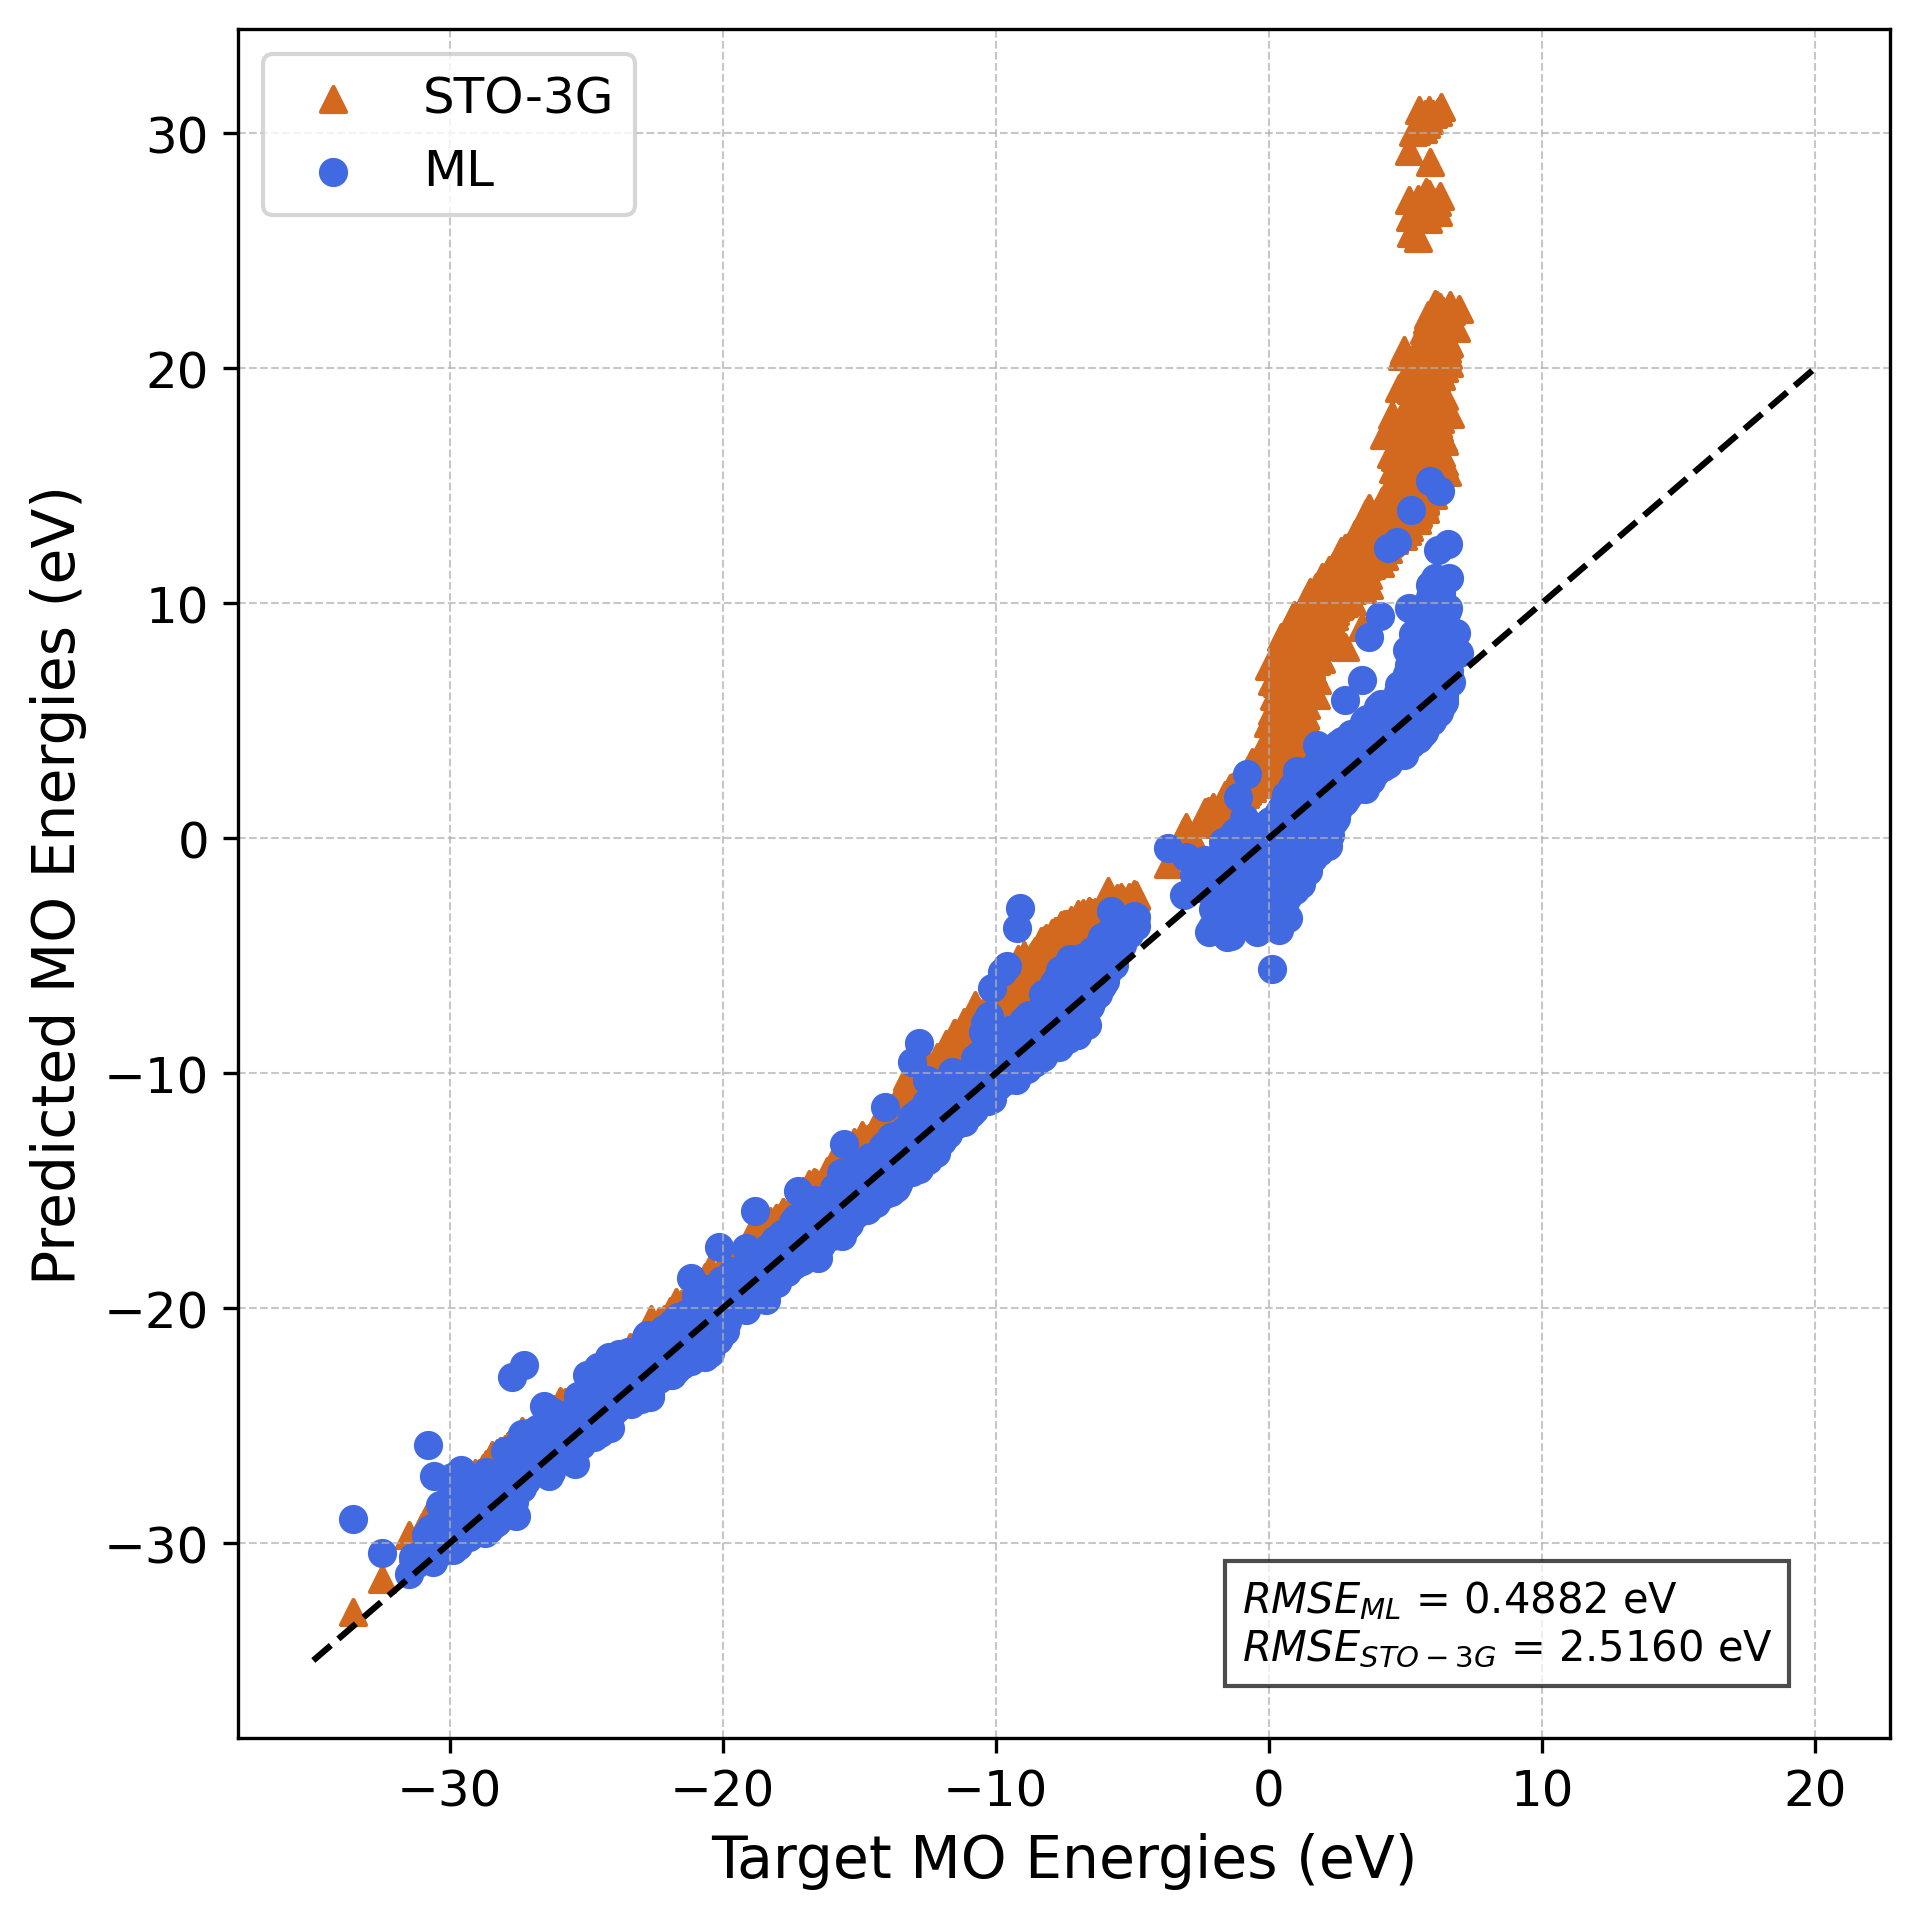

In [42]:
plt.figure(figsize=(6.5,6.5), dpi=300)  # Increase figure size and resolution
for target, predicted in zip(qm9_eva_ref_lb, [qm9_ref_eva[i] for i in ml_data_qm9.train_idx]):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree

    x = x[x > -100]
    y = y[y > -100]
    plt.scatter(x, y, color='chocolate', marker='^',
                label='STO-3G' if 'STO-3G' not in plt.gca().get_legend_handles_labels()[1] else "")
    
for target, predicted in zip(qm9_eva_ref_lb, qm9_eva_pred):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree

    x = x[x > -100]
    y = y[y > -100]
    plt.scatter(x, y, color='royalblue',
                label='ML' if 'ML' not in plt.gca().get_legend_handles_labels()[1] else "")


plt.plot([-35, 20], [-35, 20], linestyle='--', color='black', linewidth=1.5)
plt.xlabel('Target MO Energies (eV)', fontsize=14)
plt.ylabel('Predicted MO Energies (eV)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


rmse_ml = torch.sqrt(qm9_error_eva).item() * Hartree
rmse_sto3g = torch.sqrt(qm9_error_eva_STO3G).item() * Hartree
plt.text(-1, -35,
         f'$RMSE_{{ML}}$ = {rmse_ml:.4f} eV\n$RMSE_{{STO-3G}}$ = {rmse_sto3g:.4f} eV',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Legend
plt.legend(fontsize=12, loc='upper left')

plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"{FOLDER_NAME}/qm9_eva_indirect.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"{FOLDER_NAME}/qm9_eva_indirect.svg", bbox_inches="tight")  # For vector format

plt.show()

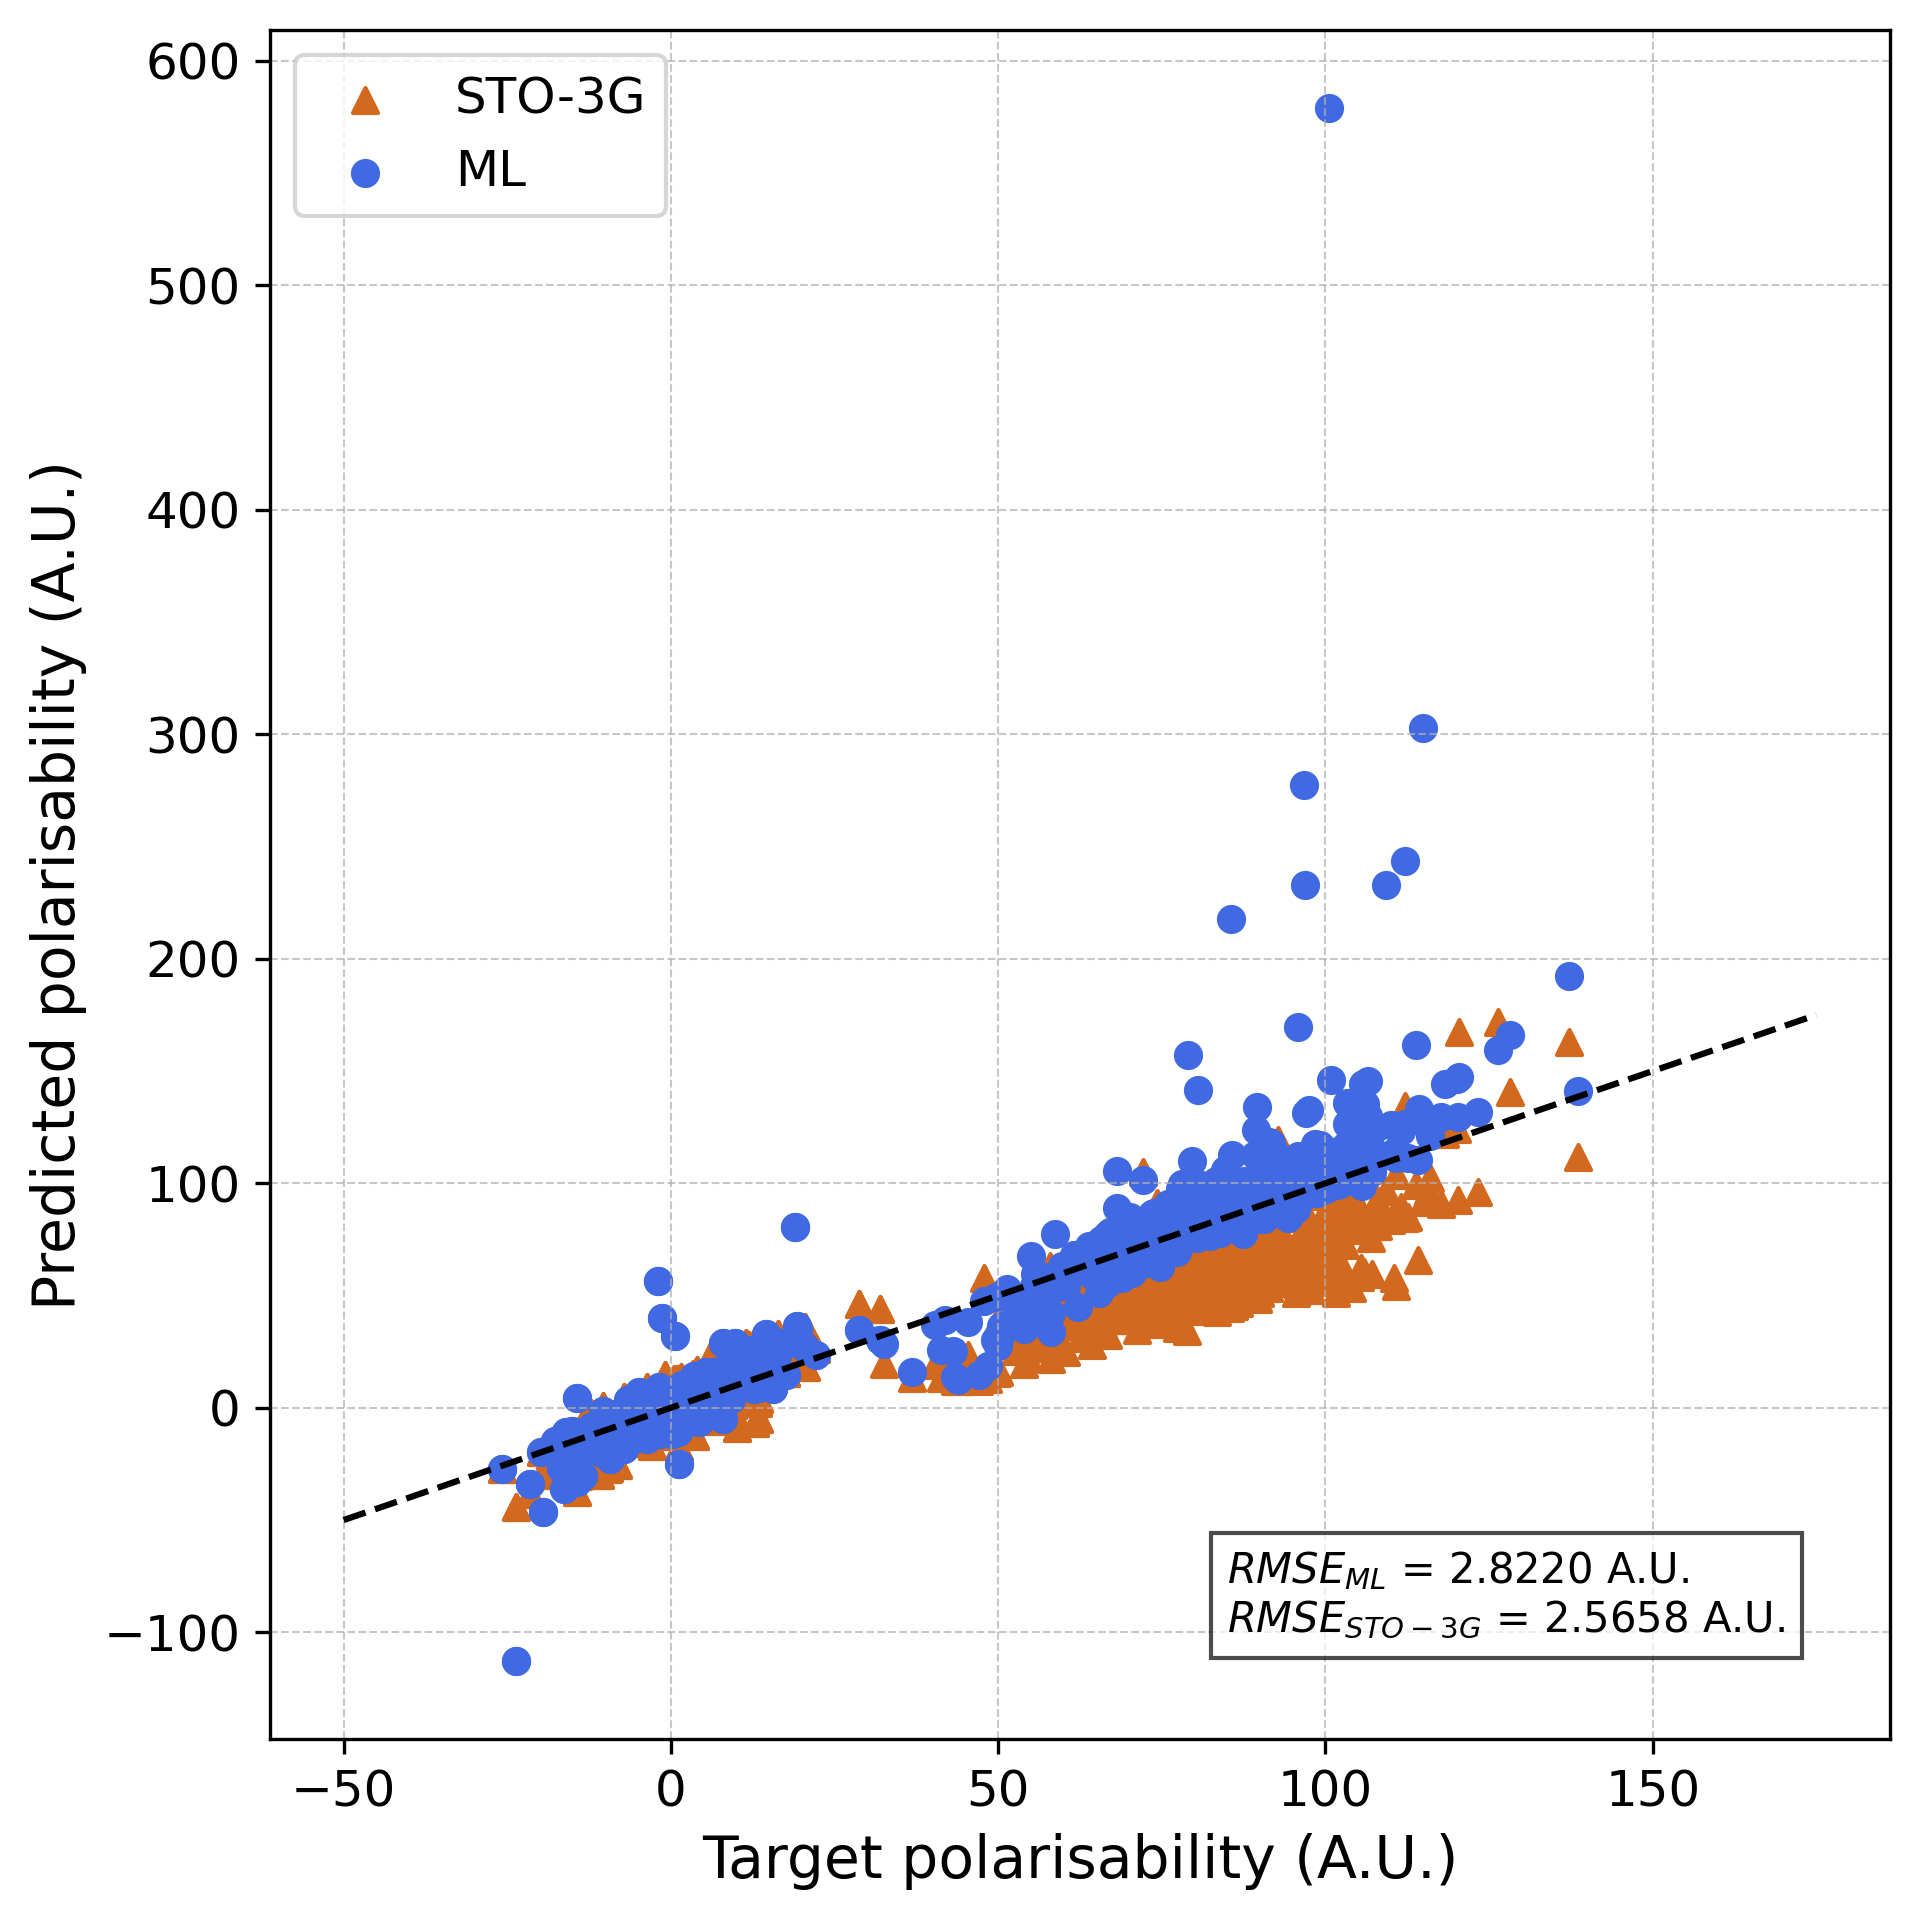

In [45]:
plt.figure(figsize=(6.5,6.5), dpi=300)  # Increase figure size and resolution
for predicted, target in zip(qm9_ref_polar[ml_data_qm9.train_idx], qm9_ref_polar_lb[ml_data_qm9.train_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='chocolate', marker='^',
                label='STO-3G' if 'STO-3G' not in plt.gca().get_legend_handles_labels()[1] else "")

for predicted, target in zip(qm9_polar_pred.detach().numpy(), qm9_ref_polar_lb[ml_data_qm9.train_idx]):
    x = target
    y = predicted
    plt.scatter(x, y, color='royalblue', 
                label='ML' if 'ML' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.plot([-50, 175], [-50, 175], linestyle='--', color='black', linewidth=1.5)
plt.xlabel('Target polarisability (A.U.)', fontsize=14)
plt.ylabel('Predicted polarisability (A.U.)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

rmse_ml = torch.sqrt(qm9_error_pol).item()
rmse_sto3g = torch.sqrt(qm9_error_polar_STO3G).item()
plt.text(85, -100,
         f'$RMSE_{{ML}}$ = {rmse_ml:.4f} A.U.\n$RMSE_{{STO-3G}}$ = {rmse_sto3g:.4f} A.U.',
         fontsize=10,
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Legend
plt.legend(fontsize=12, loc='upper left')

plt.xticks(fontsize=12)  # Increase tick font size
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(f"{FOLDER_NAME}/qm9_polar_indirect.pdf", bbox_inches="tight", dpi=300)
plt.savefig(f"{FOLDER_NAME}/qm9_polar_indirect.svg", bbox_inches="tight")  # For vector format

# plt.savefig(f"{FOLDER_NAME}/qm9_polar_indirect.pdf", bbox_inches="tight")